# 生成对抗示例
----为图像添加难以察觉的扰动会导致模型性能大不相同  
  
  
本次使用快速梯度符号攻击算法(**FGSM**, 最流行的攻击方法之一)来迷惑MNIST分类器  
  FGSM是一种白盒攻击(攻击者具有对模型的全部知识和访问权限，包括体系结构、输入、输出和权重)，目标是错误分类(攻击者只希望输出分类错误，但不关心新分类是什么)。  
  快速梯度标志攻击（FGSM），是迄今为止最早和最受欢迎的对抗性攻击之一，它由 Goodfellow 等人在[Explaining and Harnessing Adversarial Examples] (https://arxiv.org/abs/1412.6572)
  中提出，是一种简单但是有效的对抗样本生成算法。它旨在通过**利用模型学习的方式和渐变来攻击神经网络。攻击调整输入数据以基于相同的反向传播梯度来最大化损失，而不是通过基于反向传播的梯度调整权重来最小化损失**。换句话说，攻击是利用损失函数的梯度，然后调整输入数据以最大化损失。

## 1. 实现

### 1.1 导入包

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 1.2 输入
* epsilons：用于运行的epsilon值列表。在列表中保留0非常重要，因为它表示原始测试集上的模型性能。而且，我们期望epsilon越大，扰动就越明显，但就降低模型精度方面而言攻击越有效。由于此处的数据范围为[0,1]，因此epsilon值不应超过1。  
* pretrained_model：pytorch/examples/mnist训练的预训练MNIST模型的路径。  
* use_cuda：如果需要和可使用CUDA的布尔标志。注意，带有CUDA的GPU对本教程并不重要，因为本教程使用CPU不会花费太多时间。 

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained = "data/lenet_mnist_model.pth"
use_cuda = False

### 1.3 被攻击的模型
  
受攻击的模型就是上文提到的 MNIST 模型相同。也可以训练并保存自己的 MNIST 模型。此处的 Net 定义和测试数据加载器已从 MNIST 示例中复制。本节定义模型和数据加载器，然后初始化模型并加载预训练的权重。 

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [4]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train = False, download = True,
                  transform = transforms.Compose([
                      transforms.ToTensor(),
                  ])),
    batch_size = 1, shuffle = True)

In [5]:
print("CUDA available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("device: ", device)

CUDA available:  True
device:  cpu


In [6]:
model = LeNet().to(device)
model.load_state_dict(torch.load(pretrained, map_location = "cpu"))
# 在评估模式下设置模型。在这种情况下，这适用于Dropout图层 
model.eval()

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### 1.4 FGSM算法攻击

In [7]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    # 通过调整输入图像的每个像素来创建扰动图像
    perturbed_image = image + epsilon * sign_data_grad
    # 添加剪切以维持[0,1]范围
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

### 1.5 测试函数
  
每次调用此测试函数都会对 MNIST 测试集执行完整的测试步骤，并报告最终的准确性。此函数也需要输入epsilon。这是因为test函数展示受到强度为ε的攻击下被攻击模型的准确性。对于测试集中的每个样本，该函数计算输入数据的损失梯度，用fgsm_attack（perturbed_data）创建扰乱图像，然后检查扰动的例子是否是对抗性的。除了测试模型的准确性之外，该函数还保存并返回一些成功的对抗性示例，以便可视化

In [8]:
def test(model, test_loader, epsilon):
    correct = 0
    adv_examples = []
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # 设置张量的requires_grad属性，这对于攻击很关键
        data.requires_grad = True
        output = model(data)
        # 得到最大的log-probability
        init_pred = output.max(1, keepdim = True)[1]
        
        # 如果初始预测是错误的，不打断攻击，继续
        if init_pred.item() != target.item():
            continue
        
        # ⭐⭐⭐⭐开始了
        loss = F.nll_loss(output, target)
        
         # 将所有现有的渐变归零, 计算后向传递模型的梯度 
        model.zero_grad()
        loss.backward()
        
        # 收集data grad
        data_grad = data.grad.data
        # FGSM攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # 重新分类受扰乱的图像
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim = True)[1]
        
        if final_pred.item() == target.item():
            # 预测仍然正确
            correct += 1
            # 保存epsilon为0示例的特例
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # 预测错误,且只记录预测错误的
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    
    # 计算该epsilon的最终准确度
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {} \tTest Accuracy = {} / {} = {}".format(epsilon, correct, 
                                                              len(test_loader), final_acc))
    return final_acc, adv_examples

### 1.6 运行攻击
  
epsilons 中的每个 epsilon 值都运行一个完整的测试步骤。 对于每个epsilon保存最终的准确性，并在接下来的部分中绘制一些成功的对抗性示例。  
注意随着 epsilon 值的增加，精度的变化。另外，ε= 0 的情况表示原始测试精度，没有攻击。 

In [9]:
accuracies = []
examples = []

for ep in epsilons:
    acc, ex = test(model, test_loader, ep)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0 	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05 	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1 	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15 	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2 	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25 	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3 	Test Accuracy = 869 / 10000 = 0.0869


## 2 结果

### 2.1 epsilon与准确度
  
epsilon值线性分布，但是曲线中的趋势不是线性的。例如，ε= 0.05 时的精度仅比 ε= 0 低约 4％，但ε= 0.2 时的精度比 ε= 0.15 低 25％。另外在 ε= 0.25 和 ε= 0.3 之间模型的准确性达到10级分类器的**随机精度**。 

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

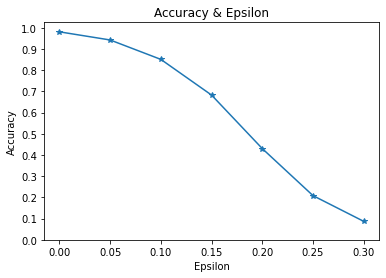

In [11]:
plt.figure()
# plt.figure(figsize = (5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy & Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### 2.2 样本对抗性示例
  

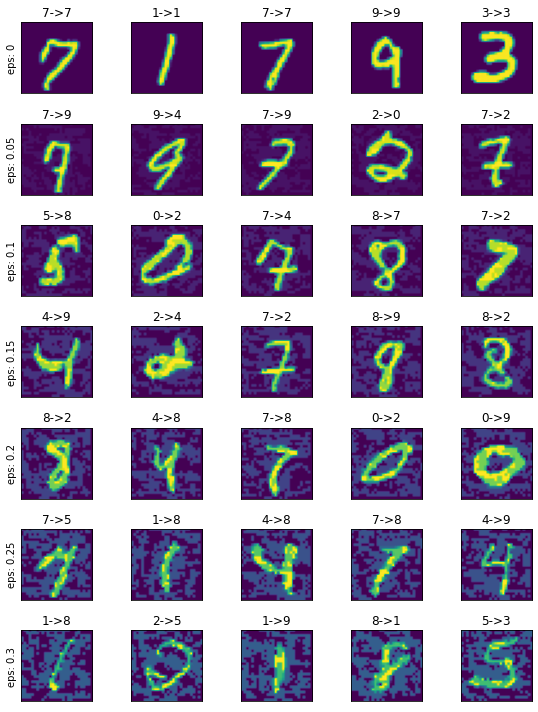

In [12]:
cnt = 0
plt.figure(figsize = (8, 10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("eps: {}".format(epsilons[i]), fontsize = 10)
        init, final, ex = examples[i][j]
        plt.title("{}->{}".format(init, final))
        plt.imshow(ex)
        # plt.imshow(ex, cmap = "gray")

plt.tight_layout() 
plt.show()